<center><h1><b>RED NEURONAL PARA LA CLASIFICACIÓN MORFOLÓGICA A PARTIR DE LA RESPUESTA DEL REGISTRO DE GAMMA RAY EN POZOS DE PETRÓLEO EMPLEANDO TÉCNICAS DE PROCESAMIENTO DE LENGUAJE NATURAL</b></h1></center>

# DEFINICION DEL PROBLEMA



Un modelo geológico busca resolver tres preguntas ¿Qué rocas hay en el área?, ¿Cuál fue su ambiente de depósito?  Y ¿Qué geometría tienen las rocas en el área?, para responder a las dos primeras preguntas se podrían taladrar pozos extrayendo la roca intacta, pero al ser pozos de varios kilómetros de longitud esta solución es económicamente inviable.

El método utilizado actualmente consiste en enviar una sonda con sensores de radiación gamma provenientes del Uranio, Torio y Potasio provenientes de las rocas. Esto permite clasificar las rocas en dos grupos: rocas arenosas (poco radioactivas) y rocas arcillosas (radioactivas).  A partir de los cambios en el tipo de roca a lo largo del pozo se identifican los diferentes **ambientes** de depósito.

La interpretación del registro de rayos gamma esta sujeta del interprete en las definiciones de ¿Qué es una roca completamente arenosa?, ¿Qué es una roca completamente arcillosa?, ¿Cuáles son los limites de cada ambiente de depósito? Y ¿Cuál es la clasificación de cada ambiente?


# IMPORTACIÓN DE LIBRERIAS



In [50]:
import os
import sys
import math
import numpy             as np
import pandas            as pd
import random            as rd
import shutil            as sht
import tensorflow        as tf
import matplotlib.pyplot as plt
from   sklearn.decomposition       import PCA
from   sklearn.manifold            import TSNE
from   tensorflow.keras.optimizers import Adam
from   tensorflow.keras.models     import Model
from   tensorflow                  import keras
from   gensim.models               import word2vec
from   sklearn.decomposition       import KernelPCA
from   tensorflow.keras.utils      import plot_model
from   sklearn.model_selection     import train_test_split
from   tensorflow.keras.losses     import MeanSquaredError
from   tensorflow.keras.layers     import Input, Dense, Activation

# DEFINICIÓN DE FUNCIONES

In [51]:
#__________________________________________________________________________________________________

def Manejo_rutas (colab_o_local='local'):

    if colab_o_local == 'local':
        re = '../02_input'
        rs = '../03_output'
    elif colab_o_local == 'colab':

        from google.colab import drive
        drive.mount('/content/drive')

        re = '/content/drive/MyDrive/aux_diplomado/01_env_class_ann/02_input'
        rs = '/content/drive/MyDrive/aux_diplomado/01_env_class_ann/03_output'
    
    return re, rs
#__________________________________________________________________________________________________

def Borrar_result (rs):
        
    rutas =[rs + '/01_ambientes/todos_los_amb',
            rs + '/01_ambientes/amb_1',
            rs + '/01_ambientes/amb_2',
            rs + '/01_ambientes/amb_3',
            rs + '/01_ambientes/amb_4',
            rs + '/01_ambientes/amb_5',
            rs + '/01_ambientes/resumen_amb',
            rs + '/02_percentiles',
            rs + '/03_graficas/todos_los_amb',
            rs + '/03_graficas/amb_1',
            rs + '/03_graficas/amb_2',
            rs + '/03_graficas/amb_3',
            rs + '/03_graficas/amb_4',
            rs + '/03_graficas/amb_5']
    
    for i in rutas:
        aux = os.listdir(i)
        for j in aux:
            os.remove( i + '/' + j )
#__________________________________________________________________________________________________

def Df_amb (re, namb):
    with open (re + '/03_amb_pozos.txt', 'r') as fr:
        L_a_amb = [_.rstrip('\n').split(',') for _ in fr.readlines()]
        
    L_a_amb_dep = []
    for i in L_a_amb:
        if i != [''] and i[0][0] != '$':
            L_a_amb_dep.append( [ i[0], i[1].replace(' ',''), float(i[2]), float(i[3]) ])
            
    df_amb = pd.DataFrame(L_a_amb_dep, columns=['Pozo', 'Ambiente', 'Top', 'Bot'])

    if i == 1:
        return df_amb

    elif namb != 1:
        aux    = df_amb.groupby('Ambiente')
        df_amb = aux.sample(n=int (namb))
        return df_amb
#__________________________________________________________________________________________________

def GR_norm (GR, GR_inf, GR_sup):
    gr_nor = (GR-GR_inf) / (GR_sup-GR_inf)
    if gr_nor > 1.0:
        gr_nor = 1.0
    elif gr_nor < 0:
        gr_nor = 0.0
    return gr_nor
#__________________________________________________________________________________________________

def Zeros_fill (n_interv):
    
    if int (n_interv) <= 10:
        zeros_fill = int (1)
        return zeros_fill
    elif  10 < int (n_interv) <= 100:
        zeros_fill = int (2)
        return zeros_fill    
    elif  100 < int (n_interv) <= 1000:
        zeros_fill = int (3)
        return zeros_fill
    else:
        sys.exit('Error: El número de intervalos excede el valor permitido por la función'+
                  ' "Zeros_fill". Se debe modificar esta función para poder utilizar el número de'+
                  ' intervalos ingreasados.')
#__________________________________________________________________________________________________

def Codificacion (n_interv):

    lista_carct = []
    zeros_fill  = Zeros_fill(n_interv)
    
    for i in range (int(n_interv)):
        lista_carct.append('a' + str(i).zfill(zeros_fill))
    
    return lista_carct
#__________________________________________________________________________________________________

def Lista_interv (n_interv):
    
    len_interv  = 1 / n_interv
    list_interv = [] 
    codific     = Codificacion(n_interv)
    
    for i in range(int(n_interv)):
        if i == 0:
            interv = ( 0.0 , round(len_interv,8) , codific[i] )
            list_interv.append(interv)
            
        elif i < int(n_interv) - 1:
            interv=(round(list_interv[-1][1],8),round(list_interv[-1][1]+len_interv,8),\
                                                                            codific[i])
            list_interv.append(interv)
            
        elif i == int(n_interv) - 1:
            interv = ( round(list_interv[-1][1],8) , 1.0 , codific[i])
            list_interv.append(interv)
            
    return list_interv 
#__________________________________________________________________________________________________

def GRnorm_a_letra (GRnorm, list_interv):
    
    if np.isnan(GRnorm) == True:
        return np.nan                
    else:
        for i in range (len(list_interv)):
            if i <  len(list_interv) - 1:
                if GRnorm >= list_interv[i][0] and GRnorm < list_interv[i][1]:
                    return list_interv[i][2]                
            else:
                if GRnorm >= list_interv[i][0] and GRnorm <= list_interv[i][1]:
                    return list_interv[i][2]
#__________________________________________________________________________________________________

def Cent_no_cent (nom_pozo, conc,len_amb, Well_Df_Fil_Env):
    
    dept_i = Well_Df_Fil_Env['DEPT'].iloc[0]
    dept_j = Well_Df_Fil_Env['DEPT'].iloc[-1]
    
    ins_i = None
    ins_f = None
    
    if len(Well_Df_Fil_Env) >= len_amb:
        nramoi = True
    else:
        nramoi = False
        
    if conc == 1.0:
        
        if len(Well_Df_Fil_Env) > len_amb:
            aux1 = len(Well_Df_Fil_Env) - len_amb
            mod2 = round(aux1%2, 5)
            
            if mod2 == 0:
                aux2 = int(round(aux1/2,5))
                Well_Df_Fil_Env = Well_Df_Fil_Env.iloc[aux2:len(Well_Df_Fil_Env)-aux2].copy()
                ins_i = None
                ins_f = None
                
            if mod2!= 0:
                aux2 = round(aux1/2,5)
                aux3 = math.ceil(aux2)
                aux4 = aux3 - 1
                aux5 = [aux3,aux4]
                aux6 = rd.choice(aux5)
                aux5.remove(aux6)
                aux7 = aux5[0]
                Well_Df_Fil_Env = Well_Df_Fil_Env.iloc[aux6:len(Well_Df_Fil_Env)-aux7].copy()
                ins_i = None
                ins_f = None
                
        if len(Well_Df_Fil_Env) < len_amb:
            aux1 = abs(len(Well_Df_Fil_Env) - len_amb)
            mod2 = round(aux1%2, 5)
            
            if mod2 == 0:
                aux2 = int(round(aux1/2,5))
                aux3 = pd.Series(np.full(aux2, nom_pozo))
                aux4 = pd.Series(np.full(aux2, 0))
                aux5 = pd.concat([aux3,aux4,aux4,aux4,aux4], axis='columns')
                aux5.columns = ['WELLNAME','DEPT','GR','AMBIENTE','GR_NORM']
     
                Well_Df_Fil_Env = pd.concat([aux5,Well_Df_Fil_Env,aux5]).copy()
                
                ins_i = aux2
                ins_f = aux2
                
            if mod2!= 0:
                aux2  = round(aux1/2,5)
                aux3  = math.ceil(aux2)
                aux4  = aux3 - 1
                aux5  = [aux3,aux4]
                aux6  = rd.choice(aux5)
                aux5.remove(aux6)
                aux7  = aux5[0]
                
                aux8  = pd.Series(np.full(aux6, nom_pozo))
                aux9  = pd.Series(np.full(aux7, nom_pozo))
                
                aux10 = pd.Series(np.full(aux6, 0))
                aux11 = pd.Series(np.full(aux7, 0))
                
                aux12 = pd.concat([aux8,aux10,aux10,aux10,aux10], axis='columns')
                aux13 = pd.concat([aux9,aux11,aux11,aux11,aux11], axis='columns')
                
                aux12.columns = ['WELLNAME','DEPT','GR','AMBIENTE','GR_NORM']
                aux13.columns = ['WELLNAME','DEPT','GR','AMBIENTE','GR_NORM']
                
                Well_Df_Fil_Env = pd.concat([aux12,Well_Df_Fil_Env,aux13]).copy()
                
                ins_i = aux6
                ins_f = aux7
        
    return Well_Df_Fil_Env, nramoi, ins_i, ins_f, dept_i, dept_j
#__________________________________________________________________________________________________

def Graficar (nom_pozo, c_piso, dept_i, dept_j,ins_i,ins_f,nramoi,step, conc, len_env,
              env, l_cont, well_df_fil_amb, dmm,rs,g_graf):
    
    if g_graf == 1:
    
        nfgr=nom_pozo +'_niv_'+str(c_piso)+'_amb_'+env +'_'+str(l_cont[int(env)-1]).zfill(3)+'.png'
            
        if conc == 0.0:
            num_reg = len(well_df_fil_amb)
            plt.figure(figsize=(10./2.54,dmm/25.4 * num_reg), facecolor='whitesmoke')
            vec_prof    = well_df_fil_amb['DEPT']
            vec_GR_norm = well_df_fil_amb['GR_NORM']
            plt.ylim(well_df_fil_amb['DEPT'].iloc[0], well_df_fil_amb['DEPT'].iloc[-1])
            plt.fill_betweenx(vec_prof, vec_GR_norm, 0, zorder = 0, color ='silver')
            plt.fill_betweenx(vec_prof, vec_GR_norm, 1, zorder = 0, color = 'gold')
            
        elif conc == 1.0 and nramoi == True:
            plt.figure(figsize=(10./2.54,dmm/25.4 * len_env), facecolor='whitesmoke')
            vec_prof    = well_df_fil_amb['DEPT']
            vec_GR_norm = well_df_fil_amb['GR_NORM']
            plt.ylim(well_df_fil_amb['DEPT'].iloc[0], well_df_fil_amb['DEPT'].iloc[-1])
            plt.fill_betweenx(vec_prof, vec_GR_norm, 0, zorder = 0, color ='silver')
            plt.fill_betweenx(vec_prof, vec_GR_norm, 1, zorder = 0, color = 'gold')
            
        elif conc == 1.0 and nramoi == False:
            plt.figure(figsize=(10./2.54,dmm/25.4 * len_env), facecolor='whitesmoke')
            aux1  = step * ins_i
            aux2  = step * ins_f
            
            aux3 = dept_i - aux1
            aux4 = dept_j + aux2
            
            aux5 = [aux3  , dept_i] 
            aux6 = [dept_j, aux4]
            
            aux7 = [0,0]
            aux8 = [0,0]
            
            aux9 = well_df_fil_amb[(well_df_fil_amb['AMBIENTE']!=0) & (well_df_fil_amb['DEPT']!=0)]
            
            vec_prof    = aux5 + list(aux9['DEPT']) + aux6
            vec_GR_norm = aux7 + list(aux9['GR_NORM']) + aux8
            
            plt.ylim(aux3, aux4)
            plt.fill_betweenx(aux9['DEPT'], aux9['GR_NORM'], 0, zorder = 0, color ='silver')
            plt.fill_betweenx(aux9['DEPT'], aux9['GR_NORM'], 1, zorder = 0, color = 'gold')
            
        plt.plot(vec_GR_norm, vec_prof, linewidth=0.50, color='black')    
        plt.xlim(0,1)
        plt.gca().invert_yaxis()
        plt.grid()
        plt.title('PROF. VS G.R_norm\n(Pozo: {}, Nivel: {}, Amb.: {})'.format(nom_pozo,c_piso,env))
        plt.xlabel('GR_normalizado')
        plt.ylabel('Profundidad [ft]')
        plt.savefig(rs + '/03_graficas/todos_los_amb/'+nfgr, bbox_inches='tight',pad_inches=0.1)
        plt.close()
#__________________________________________________________________________________________________

def Gen_csv_amb (g_csv, well_df_fil_amb_cent_o_no,rs,nfile):
    if g_csv == 1:
        well_df_fil_amb_cent_o_no.to_csv(rs + '/01_ambientes/todos_los_amb/' + nfile, 
                                    index=False, columns=['DEPT','GR_NORM', 'CARACTER','AMBIENTE'])
#__________________________________________________________________________________________________

def Filt_top_bot (i,L_lin_ag_df, well_df, top, bot):
    
    if i < len(L_lin_ag_df) -1:
        filt = (well_df['DEPT'] >= top) & (well_df['DEPT'] < bot)
    else:
        filt = (well_df['DEPT'] >= top) & (well_df['DEPT'] <= bot)
        
    return filt
#__________________________________________________________________________________________________

def GR_qt_inf_sup (tg, well_df, nom_pozo):
    
    if tg == 0:
        GR_qt_inf = well_df['GR'].quantile(q_inf)
        GR_qt_sup = well_df['GR'].quantile(q_sup)
        return GR_qt_inf, GR_qt_sup
    
    if tg == 1:
        nom_pozo_aux = nom_pozo.split('_noi_')[0]
        GR_qt_inf    = df_tope.loc[nom_pozo_aux, 'Arena']
        GR_qt_sup    = df_tope.loc[nom_pozo_aux, 'Shale']
        return GR_qt_inf, GR_qt_sup
#__________________________________________________________________________________________________

def Guar_por_amb (rs,g_csv, g_graf):
    if g_csv == 1:
        ruta_csv = rs + '/01_ambientes/todos_los_amb'
        arch_csv = os.listdir(ruta_csv)
        for i in arch_csv:
            if 'amb_1' in i:
                sht.copyfile(ruta_csv + '/' +i, ruta_csv[:-13] + 'amb_1'+'/'+i)
            elif 'amb_2' in i:
                sht.copyfile(ruta_csv + '/' +i, ruta_csv[:-13] + 'amb_2'+'/'+i)
            elif 'amb_3' in i:
                sht.copyfile(ruta_csv + '/' +i, ruta_csv[:-13] + 'amb_3'+'/'+i)
            elif 'amb_4' in i:
                sht.copyfile(ruta_csv + '/' +i, ruta_csv[:-13] + 'amb_4'+'/'+i)
            elif 'amb_5' in i:
                sht.copyfile(ruta_csv + '/' +i, ruta_csv[:-13] + 'amb_5'+'/'+i)
    
    if g_graf == 1:
        ruta_grf = rs + '/03_graficas/todos_los_amb'
        arch_grf = os.listdir(ruta_grf)
        for i in arch_grf:
            if 'amb_1' in i:
                sht.copyfile(ruta_grf + '/' +i, ruta_grf[:-13] + 'amb_1'+'/'+i)
            elif 'amb_2' in i:
                sht.copyfile(ruta_grf + '/' +i, ruta_grf[:-13] + 'amb_2'+'/'+i)
            elif 'amb_3' in i:
                sht.copyfile(ruta_grf + '/' +i, ruta_grf[:-13] + 'amb_3'+'/'+i)
            elif 'amb_4' in i:
                sht.copyfile(ruta_grf + '/' +i, ruta_grf[:-13] + 'amb_4'+'/'+i)
            elif 'amb_5' in i:
                sht.copyfile(ruta_grf + '/' +i, ruta_grf[:-13] + 'amb_5'+'/'+i)
#__________________________________________________________________________________________________

def Read_ent_gen (re):
    ent_gen = list(np.loadtxt(re + '/01_dat_gen.txt', skiprows=2,usecols=0))
    ent_gen[0] = int(ent_gen[0])
    return ent_gen
#__________________________________________________________________________________________________

# PREPROCESAMIENTO DE DATOS

## IMPLEMENTACIÓN DEL RUIDO GAUSSIANO

Ya que el proceso de obtención de mediciones de Gamma Ray (GR) en pozos de petróleos es bastante costoso para las empresas, no fue factible para el proceso de entrenamiento de la red tener una gran cantidad de muestras de forma gratuita.  Para solucionar esto se optó por generar gráficas de GR para el entrenamiento de manera artificial usuando ruidos gausianos a una magnitud que no modifique la clasificación asignada inicialmente al ambiente.

La siguiente imagen ilustra la idea anterior:

![picture](https://drive.google.com/uc?export=view&id=1o2HG36rgjIFLdZ2ZzKgm9yNg5_94xrnb)

En la anterior imagen, la gráfica izquierda corresponde al registro original, mientras que la derecha tiene aplicado el ruido gaussiano.

Para el proceso de entrenamiento se generaron $25$ registros con ruido gaussiano por cada registro original.

In [52]:
#__________________________________________________________________________________________________

re, rs = Manejo_rutas (colab_o_local='colab')

Borrar_result(rs)

n,factor, quant,namb, conc,g_csv,g_graf,len_env,tg,q_inf,q_sup,step,n_interv,dmm=Read_ent_gen (re)

df_amb       = Df_amb(re,namb)
L_nom_pozos  = list (df_amb['Pozo'].unique())

df  = pd.read_csv(re + '/02_data_set_well_logs.csv', usecols=[5,17,20])[['WELLNAME','DEPT','GR']]
df.set_index('WELLNAME',inplace=True)
df           = df.loc[L_nom_pozos].reset_index()
well_grp_df_rg  = df.groupby('WELLNAME', sort=False)
#__________________________________________________________________________________________________

for nom_pozo in L_nom_pozos:
    
    well_df = well_grp_df_rg.get_group(nom_pozo).copy().reset_index(drop=True)
    GR_quant = well_df['GR'].quantile(quant)
    
    for i in range(n):
        
        well_df_noise = well_df.copy()
        well_df_noise['GR'] = well_df_noise['GR'].apply\
            (lambda x: x + np.random.normal()*factor*GR_quant)
            
        well_df_noise['WELLNAME'] = nom_pozo + '_noi_' + str(i+1)
        
        df = df.append(well_df_noise,ignore_index=True)
#__________________________________________________________________________________________________
        
well_grp_df_amb  = df_amb.groupby('Pozo', sort=False)
for i in well_grp_df_amb:
    for j in range(n):
        df_noi_ij = i[1].copy()
        df_noi_ij['Pozo'] = i[0] + '_noi_' + str (j+1)
        df_amb = df_amb.append(df_noi_ij,ignore_index=True)
#__________________________________________________________________________________________________

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## OBTENCIÓN DEL CORPUS

Uno de los principales problemas de este estudio proviene del hecho de que cada medición de Gamma Ray (GR) para un pozo tiene una cantidad de registros altamente variable y por lo tanto los ambientes serán considerablemente variables en longitud. Para trabajar con estos conjuntos de longitudes desiguales se decidió abordar el problema como un problema de ***procesamiento del lenguaje natural***. 

Ya que el rango de los datos permanece entre $[0,1]$ se dividió el intervalo en 100 subintervalos de $0.01$ y se le asignó a cada uno de los intervalos las palabras desde $a00$ hasta $a99$ siendo así cada ambiente un documento de texto.

Para el presente estudio se tokenizó cada documento por palabras, de forma que el corpus del análisis se constituye por el conjunto de palabras $\{a00,...,a99\}$.

El siguente esquema ilustra lo anterior:

![picture](https://drive.google.com/uc?export=view&id=1CsaculFAU3FpdOifSu6wOqP6BnbhL4xt)




In [53]:
#__________________________________________________________________________________________________

list_interv = Lista_interv(n_interv)

df['DEPT']  = (df['DEPT']/0.3048).round(8)    
well_grp_df = df.groupby('WELLNAME')

well_grp_df_amb  = df_amb.groupby('Pozo', sort=False)

df_tope =  pd.read_csv(re + '/04_bases_arena_shale.csv',
                        dtype={'Arena':float, 'Shale':float}).set_index('Pozo')
#__________________________________________________________________________________________________

l_perc     = []
l_cont     = [0,0,0,0,0]
l_resm_env = []
corpus     = []
label_amb  = []

for amb_pozo in well_grp_df_amb:

    nom_pozo    = amb_pozo[0]
    L_lin_ag_df = amb_pozo[1].drop('Pozo', axis='columns')
    L_lin_ag_df['Ambiente'] = L_lin_ag_df['Ambiente'].astype(str)

    #______________________________________________________________________________________________
    
    well_df   = well_grp_df.get_group(nom_pozo).copy().reset_index(drop=True)
    
    GR_min    = well_df['GR'].min()
    GR_max    = well_df['GR'].max()
    GR_qt_inf, GR_qt_sup = GR_qt_inf_sup (tg, well_df, nom_pozo)
    #______________________________________________________________________________________________
    
    c_piso = 0
    for i in range(len(L_lin_ag_df)):
        
        c_piso += 1
        
        env  = L_lin_ag_df.iloc[i,0]
        top  = L_lin_ag_df.iloc[i,1]
        bot  = L_lin_ag_df.iloc[i,2]
        
        filt = Filt_top_bot (i,L_lin_ag_df, well_df, top, bot)
            
        well_df_fil_amb = well_df[filt].copy()
        
        well_df_fil_amb['AMBIENTE'] = env
        well_df_fil_amb['GR_NORM']  = well_df_fil_amb['GR'].apply(GR_norm, 
                                                            args=(GR_qt_inf,GR_qt_sup))
        
        well_df_fil_amb_cent_o_no,nramoi,ins_i,ins_f,dept_i, dept_j =Cent_no_cent(nom_pozo,conc,
                                                                        len_env,well_df_fil_amb)
                                                  
        well_df_fil_amb_cent_o_no['CARACTER'] = well_df_fil_amb_cent_o_no['GR_NORM'].apply\
                                                              (GRnorm_a_letra, args=(list_interv,))
        
        corpus.append(list (well_df_fil_amb_cent_o_no['CARACTER']))
        label_amb.append(env)        
        
        l_cont[int(env)-1] = l_cont[int(env)-1] + 1                                          
        
        Graficar(nom_pozo, c_piso,dept_i, dept_j,ins_i,ins_f,nramoi, step, conc, len_env, env,
                                                    l_cont,well_df_fil_amb_cent_o_no,dmm,rs,g_graf)     
                    
        nfile=nom_pozo+'_niv_'+str(c_piso)+'_amb_'+env +'_'+str(l_cont[int(env)-1]).zfill(3)+'.csv'
        
        Gen_csv_amb (g_csv, well_df_fil_amb_cent_o_no,rs,nfile)
        
        l_resm_env.append([nfile[:-4],int(env),nom_pozo,c_piso,top,bot])
#__________________________________________________________________________________________________

resm_df = pd.DataFrame(l_resm_env,columns=['Nombre_amb','Ambiente','Pozo','Nivel', 'Top','Bot']) 
if g_csv == 1:                                                            
    resm_df.to_csv(rs + '/01_ambientes/resumen_amb/Resumen_ambientes.csv',index=False)

perc_df = pd.DataFrame(l_perc,columns=['POZO','GR_MIN','GR_MAX','GR_PER_5','GR_PER_95'])  
if g_csv == 1:                                                            
    perc_df.to_csv(rs + '/02_percentiles/GR_perc_pozos.csv',index=False)

Guar_por_amb(rs,g_csv, g_graf)
#__________________________________________________________________________________________________

## DEPURACIÓN DEL CORPUS - ELIMINACIÓN DE VALORES nan

Dado que la sonda que se envía para tomar los registros de Gamma Ray puede dejar de tomar registros en ciertos puntos por diversos problemas que se puedan presentar (por ejemplo: se derrumba las paredes de la performación lo cual afecta el equipo), en algunos pozos con los que trabajó no se tiene registro de Gamma Ray en cierto rango de profundidades. Para solucionar este incoveniente de valores faltantes, se optó por suprimir estos registros. El siguiente esquema ilustra lo anterior:

![picture](https://drive.google.com/uc?export=view&id=1bD2st1u1XXtoJdzBBaaagS8Pvh7SqqYI)


In [54]:
corpus_s_nan = []
for i in corpus:
    corpus_s_nan.append(list (pd.Series(i).dropna()))

## DEFINICIÓN DEL CONJUNTO DE DATOS DE ENTRENAMIENTO Y PRUEBA

In [55]:
random_state = 60
x_train, x_test, y_train, y_test = train_test_split(corpus_s_nan, label_amb, test_size=0.20,
                                                                  random_state=random_state)

## TRANSFORMACIÓN DE LOS ELEMENTOS DEL CORPUS (TEXTO A VECTORES) EMPLEANDO Word2Vec

Como función de embedding se utilizó *word2vec* con el fin de transformar cada palabra en un vector de $10$ entradas y posteriormente obtener un vector representativo (también de $10$ entradas) de cada documento por medio de promediar cada conjunto de vectores que lo conforman.

Una ventaja importante del método recien descrito, es que al final todos los registros (que inicialmente tenían longitudes variables) van a tener la misma longitud ($10$), lo cual facilita la construcción de la red neuronal, pues la capa de entrada será siempre de $10$ neuronas (como se verá más adelnate).

La siquiente gráfica ilustra lo anterior:

![picture](https://drive.google.com/uc?export=view&id=10flF5HKgNdjXEIOWHqalIDA_p-H7FEt3)

Se decidió utilizar una ventana de contexto de 100 palabras con el fin de recoger en longitud física un total de 30 metros, que según nuestro experto es en promedio las distancias en las que se presentan cambios importantes en los pozos.

In [56]:
feature_size   = 10
window_context = 100                        
min_word_count = 1
sample         = 1e-3

w2v_model = word2vec.Word2Vec(x_train, window=window_context, 
                              min_count=min_word_count, sample=sample, size=feature_size)
                          
wvs = w2v_model.wv[Codificacion (n_interv)]

dict_pal_vec = dict (zip(Codificacion (n_interv) ,  wvs))

corp_transf_train  = []

for i in x_train:
    aux  = [] 
    for j in i:
        aux.append(dict_pal_vec[j])
    prom = np.mean(np.array(aux),axis=0)
    corp_transf_train.append(list (prom))

corp_transf_train_np = np.array(corp_transf_train)

# RED NEURONAL

## DEFINICIÓN DE LA ARQUITECTURA DE LA RED NEURONAL

El problema en sí es un problema básico de clasificación, una vez obtenidos los tensores representativos de cada documento de tamaño estándar se procede a alimentar una red con una capa de entrada de 10 neuronas y dos capaz densas de 20 y 10 neuronas con activación relu y una capa de salida softmax con 5 neuronas las cuales representan las 5 clases de ambientes.

In [57]:
# Construcción del modelo

model = keras.models.Sequential([
 keras.layers.Input(shape=[10,]),
 keras.layers.Dense(20, activation="relu"),
 keras.layers.Dense(10, activation="relu"),
 keras.layers.Dense(5 , activation="softmax")
])

# Parámetros del modelo

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 55        
Total params: 485
Trainable params: 485
Non-trainable params: 0
_________________________________________________________________


## ENTRENAMIENTO DE LA RED NEURONAL

In [58]:
history = model.fit(corp_transf_train_np, np.array(y_train,dtype=int) - 1, epochs = 100, 
                                                                   validation_split=0.1)

# En esta parte se guarda el modelo
aux = os.listdir(rs + '/04_ann_model')
aux1 = str (len(aux)+1).zfill(2)
model.save(rs + '/04_ann_model/' +'execution_'+aux1+'_ann_results' + '/ann_model.h5')

Epoch 1/100
2/2 [==============================] - 1s 191ms/step - loss: 1.9982 - accuracy: 0.1736 - val_loss: 1.7206 - val_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 0s 44ms/step - loss: 1.9782 - accuracy: 0.1736 - val_loss: 1.6942 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 0s 46ms/step - loss: 1.9291 - accuracy: 0.1736 - val_loss: 1.6698 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 0s 37ms/step - loss: 1.9120 - accuracy: 0.1632 - val_loss: 1.6467 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 1.8889 - accuracy: 0.2106 - val_loss: 1.6247 - val_accuracy: 0.5000
Epoch 6/100
2/2 [==============================] - 0s 41ms/step - loss: 1.8500 - accuracy: 0.2500 - val_loss: 1.6034 - val_accuracy: 0.5000
Epoch 7/100
2/2 [==============================] - 0s 44ms/step - loss: 1.8324 - accuracy: 0.2396 - val_loss: 1.5804 - val_accuracy: 0.5000
Epoch 8/100
2/2 [==

## GRAFICACIÓN DE RESULTADOS DE ENTRENAMIENTO

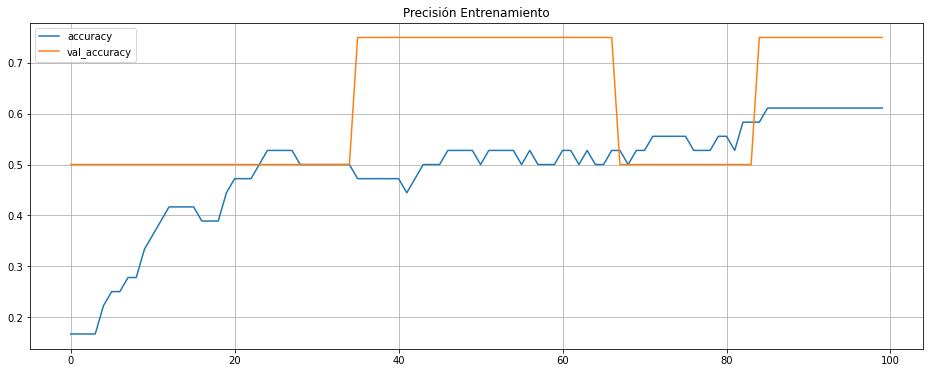

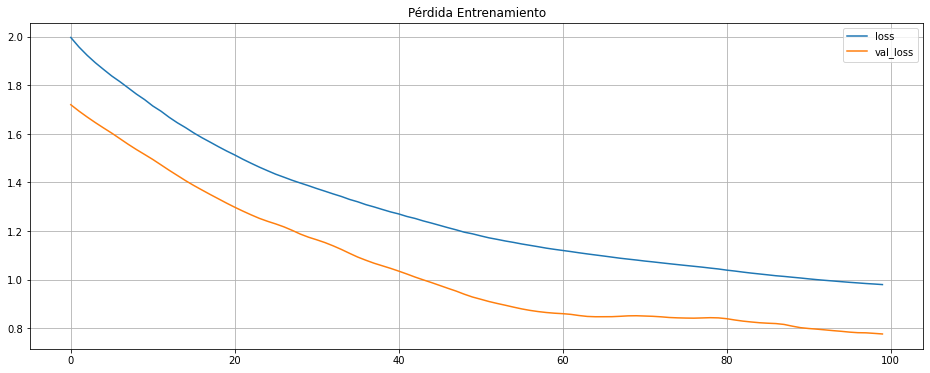

In [59]:
plt.figure(figsize=(16,6))
plt.grid()
len_epoch = len(history.history['accuracy'])
plt.plot(np.arange(0,len_epoch),history.history['accuracy'], label = 'accuracy')
plt.plot(np.arange(0,len_epoch),history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('Precisión Entrenamiento')
plt.savefig(rs + '/04_ann_model/'+'execution_'+aux1+'_ann_results'+'/Precision_Entrenamiento.png')

plt.figure(figsize=(16,6))
plt.grid()
len_epoch = len(history.history['loss'])
plt.plot(np.arange(0,len_epoch),history.history['loss'], label = 'loss')
plt.plot(np.arange(0,len_epoch),history.history['val_loss'],label='val_loss')
plt.legend()
plt.title('Pérdida Entrenamiento')
plt.savefig(rs + '/04_ann_model/' +'execution_'+aux1+'_ann_results' + '/Perdida_Entrenamiento.png')

## EVALUACIÓN DE LA RED NEURONAL CON DATOS DE PRUEBA

In [60]:
corp_transf_test  = []

for i in x_test:
    aux  = [] 
    for j in i:
        aux.append(dict_pal_vec[j])
    prom = np.mean(np.array(aux),axis=0)
    corp_transf_test.append(list (prom))

corp_transf_test_np = np.array(corp_transf_test)

model.evaluate(corp_transf_test_np, np.array(y_test,dtype=int) - 1)

1/1 [==============================] - 0s 15ms/step - loss: 1.2327 - accuracy: 0.4000


[1.232702612876892, 0.4000000059604645]

Los valores de error y precisión entre el entrenamiento, validación y test son muy similares. Los errores presentan valores bajos y precisiones muy altas superiores al 94% de manera que el clasificador tiene un alto rendimiento.